# Exploring scikit-allel
*May 2019*

Question: Will this suit our needs for our pi/dxy project?

**scikit-allel manual https://scikit-allel.readthedocs.io/en/stable/**

Setup for the notebook (see shell commands below):

- Making heavy use of Anaconda
- I created a new conda environment for scikit-allel (just called 'allel')
- I installed scikit-allel
- On my Windows machine, I had to also install ipython kernel (`ipykernel`) and add the `allel` conda environment to it as a kernel
- You can change the kernel for the notebook by clicking on the kernel name next to the circle at the top right


In [1]:
# shell commands for setup

# conda create --name allel
# conda activate allel

# conda install -c conda-forge scikit-allel
# conda install ipykernel

# ipython kernel install --user --name=allel
# conda deactivate
# conda activate allel
# jupyter lab


In [2]:
import allel
import zarr
import numcodecs
import numpy as np
import sys
import matplotlib.pyplot as plt

### 1. Read in and examine a VCF

First, we read in and convert our test VCF to zarr format:

In [3]:
chromosome = "chrX"

In [4]:
vcf_path = 'data/vcf/ag1000/chrX_36Ag_allsites.vcf.gz'
zarr_path = 'data/vcf/ag1000/chrX_36Ag_allsites.zarr'

print(zarr_path)

#allel.vcf_to_zarr(vcf_path, zarr_path, group='chrX', fields='*', log=sys.stdout, overwrite=True)

data/vcf/ag1000/chrX_36Ag_allsites.zarr


In [5]:
# inspect the zarr data

callset = zarr.open_group(zarr_path, mode='r')
callset.tree(expand=True)

/
 └── chrX
     ├── calldata
     │   ├── AD (23302924, 36, 4) int16
     │   ├── DP (23302924, 36) int16
     │   ├── GQ (23302924, 36) int8
     │   ├── GT (23302924, 36, 2) int8
     │   ├── MIN_DP (23302924, 36) int32
     │   ├── PGT (23302924, 36) object
     │   ├── PID (23302924, 36) object
     │   ├── PL (23302924, 36, 3) int32
     │   ├── RGQ (23302924, 36) int32
     │   └── SB (23302924, 36, 4) int32
     ├── samples (36,) object
     └── variants
         ├── AC (23302924, 3) int32
         ├── AF (23302924, 3) float32
         ├── ALT (23302924, 3) object
         ├── AN (23302924,) int32
         ├── BaseQRankSum (23302924,) float32
         ├── CHROM (23302924,) object
         ├── DP (23302924,) int32
         ├── DS (23302924,) bool
         ├── END (23302924,) int32
         ├── ExcessHet (23302924,) float32
         ├── FILTER_LowQual (23302924,) bool
         ├── FILTER_PASS (23302924,) bool
         ├── FS (23302924,) float32
         ├── ID (23302924,) object
         ├── InbreedingCoeff (23302924,) float32
         ├── MLEAC (23302924, 3) int32
         ├── MLEAF (23302924, 3) float32
         ├── MQ (23302924,) float32
         ├── MQRankSum (23302924,) float32
         ├── POS (23302924,) int32
         ├── QD (23302924,) float32
         ├── QUAL (23302924,) float32
         ├── RAW_MQ (23302924,) float32
         ├── REF (23302924,) object
         ├── ReadPosRankSum (23302924,) float32
         ├── SOR (23302924,) float32
         ├── altlen (23302924, 3) int32
         ├── is_snp (23302924,) bool
         └── numalt (23302924,) int32

In [8]:
# diagnostics on the zarr genotype array.


gt_zarr = callset[chromosome + '/calldata/GT']
gt_zarr.info

Name,/chrX/calldata/GT
Type,zarr.core.Array
Data type,int8
Shape,"(23302924, 36, 2)"
Chunk shape,"(65536, 36, 2)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1677810528 (1.6G)
No. bytes stored,89336639 (85.2M)


In [30]:
# get genotypes from specific positions
# first, list all the positions
pos = allel.SortedIndex(callset[chromosome + '/variants/POS'])
print(pos)

# use the 'pos' object to create a slice for a specific region
# e.g. 1:19999 in this case
loc_region = pos.locate_range(0, 20000)
print(loc_region)

0,1,2,3,4,...,23302919,23302920,23302921,23302922,23302923
1,2,3,4,5,...,24393104,24393105,24393106,24393107,24393108


slice(0, 19214, None)

In [33]:
# once we have the slice, we can use it to subset the zarr array
# nice!
gt_region = allel.GenotypeArray(gt_zarr[loc_region])
gt_region

<GenotypeArray shape=(19214, 36, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [34]:
allel.VariantTable(gt_region)

ValueError: Unknown input type

This all looks very promising!

### 2. Filtering Variants

We definitely want to be able to filter variants. Looking at the zarr array from above, it appears:

- /variants has all the site-level annotations (i.e. INFO fields)
- /calldata has the individual genotype annotations (i.e. FORMAT fields)

In [21]:
# e.g. a 1D boolean array indicated if the site is a snp (or an indel, I guess?)

is_snp = callset[chromosome + '/variants/is_snp'][:]
is_snp

array([False, False, False, ..., False, False, False])

In [27]:
# a N-D numeric array for genotype annotations, e.g. depth
# rows are individuals, columns are sites

geno_dp = callset[chromosome + '/calldata/DP'][:]
geno_dp > 22

geno_gq = callset[chromosome + '/calldata/GQ'][:]
geno_gq


array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

### A look at GQ vs RGQ

For purposes of filtration, we'd like to treat variant and invariant sites as similarly as possible. 

In an GATK 'allsites' VCF, invariant sites have only four genotype fields: GT, AD, DP, RGQ

- GT is the genotype (always 0/0 for invariant sites)
- AD is per-allele depth, which is basically redundant with DP for invariant sites
- DP the total depth (AD allele 1 + AD allele 2)
- RGQ, the "reference genotype quality"

So, really, we just have DP and RGQ to work with. First question is whether RGQ can be treated "the same" as GQ for filtration.


In [23]:
# the GQ scores
# 0/0 ref calls have -1 (which is missing, I take it)

geno_gq = callset[chromosome + '/calldata/GQ'][:]
geno_gq

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

In [24]:
# the RGQ (reference genotype quality) scores
# anything with an alt call has -1 

geno_rgq = callset[chromosome + '/calldata/RGQ'][:]
geno_rgq

array([[ 75, 108,  99, ...,  99,  66, 105],
       [ 75, 108,  99, ...,  99,  66, 105],
       [ 75, 108,  99, ...,  99,  66, 105],
       ...,
       [ -1,  -1,  -1, ...,  -1,  -1,  -1],
       [ -1,  -1,  -1, ...,  -1,  -1,  -1],
       [ -1,  -1,  -1, ...,  -1,  -1,  -1]], dtype=int32)

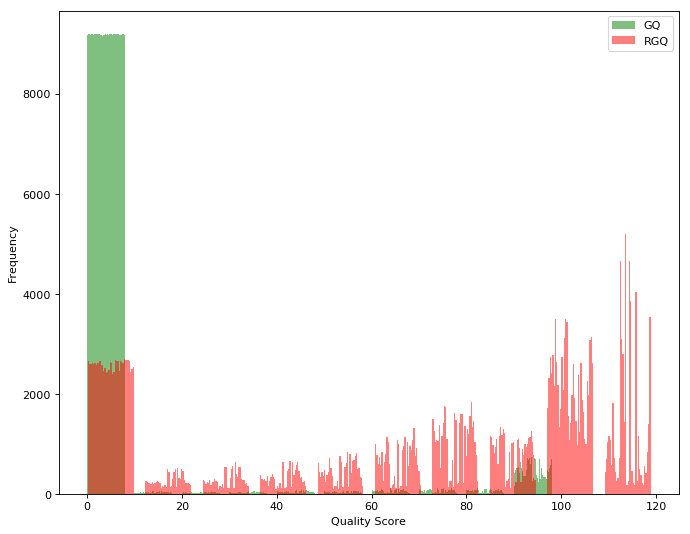

In [30]:
# quick plot of gq and rgq

# subsample down to 10000 rows for faster plotting

indices = np.random.randint(0,geno_rgq.shape[0], 10000)
geno_rgq_sub = geno_rgq[indices]

indices = np.random.randint(0,geno_gq.shape[0], 10000)
geno_gq_sub = geno_gq[indices]


%matplotlib inline

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.hist(geno_gq_sub, facecolor='g', alpha=0.5, label = "GQ")
plt.hist(geno_rgq_sub, facecolor='r', alpha=0.5, label = "RGQ")
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Quality Score')
plt.show()


### 3. Filtering at the sample level

We want to be able to: 
- Select specific samples 
- Filter individual genotypes (i.e. not only at the site level)

In [26]:
# read in the list of samples/populations

import pandas
pop_file_path = 'data/vcf/dpse/fasta_samplelist_recode.txt'
panel = pandas.read_csv(pop_file_path, sep='\t', usecols=['sample', 'id', 'pop'])
panel

,sample,id,pop
0,S1,A56,AFC
1,S2,MV2-25,MV
2,S3,M14,MC
3,S4,A60,AFC
4,S5,M17,MC
5,S6,A19,AFC
6,S7,Flag14,FLAG
7,S8,VY-F16,VY
8,S9,A12,AFC
9,S10,A47,A47


In [91]:
# get a list of samples from the callset

samples = callset[chromosome + '/samples'][:]

samples

array(['S1', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17',
       'S18', 'S19', 'S2', 'S20', 'S21', 'S22', 'S3', 'S4', 'S5', 'S6',
       'S7', 'S8', 'S9'], dtype=object)

In [107]:
# find the samples in the callset index

samples_list = list(samples)
panel['sample']
[samples_list.index(s) for s in panel['sample']]


#samples_callset_index = 
#samples_callset_index 

#loc_samples_afr = panel[panel.pop == 'AFC'].callset_index.values
#loc_samples_afr


[0, 11, 15, 16, 17, 18, 19, 20, 21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]

In [53]:
# we can intersect two filtration criteria

geno_dp = callset[chromosome + '/calldata/DP'][:]
geno_gq = callset[chromosome + '/calldata/GQ'][:]
is_snp = callset[chromosome + '/variants/is_snp'][:]

loc_variant_selection = ~is_snp & (geno_dp[:] > 0.05)

                  
                  
#is_snp
loc_variant_selection.dtype


SyntaxError: invalid syntax (<ipython-input-53-5053dbb1b16a>, line 9)

In [47]:
# extract the loci passing filter

# load the genotype matrix into memory
# weeoo
gt = allel.GenotypeArray(gt_zarr)
gt

gt_variant_selection = gt.compress(loc_variant_selection, axis = 0)
#gt_variant_selection


ValueError: bad length of condition; expected 387872, found 8533184

In [48]:
# DATA VALIDATION

# we want to check:
# - the vcf is valid (this is done by pyVCF)
# - the individuals in the population file exist in the vcf
#     - if there are inds missing, generate a warning?
# - the vcf contains invariant and variant sites
#     - if the last point is not true, refuse to continue
#     - alternatively, generate a very explicit warning about the miscalculation of pi/dxy
# - the filter expression(s) correctly refer to annotations in the VCF
#    - stop if any annotations don't exist in the file


In [ ]:
# NUCLEOTIDE DIVERSITY (PI) CALCULATION

In [ ]:
# for a single window, apply general filters to genotypes
# depth, GQ, GATK best practices filters, etc.
# might also want to consider a missingness filter here
# also ignore + remove indels!


In [ ]:
# with filtered data, extract genotypes into a matrix (??)


In [ ]:
# for a genotype matrix, count number of differences between each row (individual)
# missing sites are ignored (but reduce sample size)
# use langley formula here

# alternatively, we could compute per-site pi here and do the windows after the fact
# maybe not a bad idea
# important to keep track of numerator and denominator either way 


In [ ]:
# count missing sites (for dropping windows)
# this is kind of implicit if we track the denominators properly


In [ ]:
# compute pi over the chosen window size


In [ ]:
# generate a flat output file 
# something like:
#
# # <META = list of filtration criteria etc>.
# chrom pos1 pos2 n_inds n_sites_avg n_snps n_monomorphic pi_est/dxy_est
#
# the n_sites/n_snps/n_monomorphic will have to be averages across individuals i suppose


In [ ]:
# ABSOLUTE DIVERGENCE (DXY) CALCULATION

In [ ]:
# as with pi, apply genotype-level filters first


In [ ]:
# read in population file


In [ ]:
# create genotype matrix for each population
# (or track indexes in a single matrix)
 

In [ ]:
# count differences between all between-population pairs
# can do per-site and sum or do whole windows 

In [ ]:
# CLI will look like
pi_dxy --pi --dxy\ # compute both pi within and dxy between
--vcf allsites.vcf.gz \
--populations popfile.txt \
--window_size 10000 \
--snp_filter_expression "DP>=10, GQ>=20, FS>2" \
--monomorphic_filter_expression "DP>=10, RGQ>=20" \
--outfile pi_dxy_out.txt